In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy import stats
from sklearn.neighbors import KernelDensity

In [2]:
common_path ='subject4/'

In [3]:
lambda0 = 2
#reading dataset

dataGaze = pd.read_csv(f'{common_path}merged_data.csv')

#properties from dataset
attribs = dataGaze.columns
dataGaze.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55962 entries, 0 to 55961
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gidx                     55962 non-null  int64  
 1   timestamp                55962 non-null  int64  
 2   pupil_center_left_x      55962 non-null  float64
 3   pupil_center_left_y      55962 non-null  float64
 4   pupil_center_left_z      55962 non-null  float64
 5   pupil_center_right_x     55962 non-null  float64
 6   pupil_center_right_y     55962 non-null  float64
 7   pupil_center_right_z     55962 non-null  float64
 8   pupil_diameter_left      55962 non-null  float64
 9   pupil_diameter_right     55962 non-null  float64
 10  gaze_direction_left_x    55962 non-null  float64
 11  gaze_direction_left_y    55962 non-null  float64
 12  gaze_direction_left_z    55962 non-null  float64
 13  gaze_direction_right_x   55962 non-null  float64
 14  gaze_direction_right_y

In [4]:
#3 - Conversion To Spherical Coordinates
#In order to calculate the gaze velocity in degrees per second,
#we will have to convert the data from its cartesian coordinate system to a spherical coordinate system.
#Afterwards we plot the spherical coordinates over time and in space.
def cart_to_spherical(dataGaze, apply_rad2deg=False):
    # convert to spherical coordinates
    x = dataGaze.gaze_point_3d_x
    y = dataGaze.gaze_point_3d_y
    z = dataGaze.gaze_point_3d_z
    r = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    theta = np.arccos(y / r)  # for elevation angle defined from Z-axis down
    psi = np.arctan2(z, x)

    if apply_rad2deg:
        theta = np.rad2deg(theta)
        psi = np.rad2deg(psi)

    return r, theta, psi

def get_velocity(t, x, y):
    dt = np.diff(t)
    dx = np.diff(x)
    dy = np.diff(y)

    return np.divide(dx, dt), np.divide(dy, dt)

def sphere_pos_over_time(ts, data, unit="radians"):
    for key, values in data.items():
        sns.lineplot(x=ts, y=values, label=key)

    plt.xlabel("time [sec]")
    plt.ylabel(unit)
    plt.legend()

def sphere_pos(r, theta, psi, unit="radians"):
    print(r.min(), r.max())
    norm = colors.LogNorm(vmin=r.min(), vmax=r.max())
    points = plt.scatter(
        theta,
        psi,
        c=r,
        alpha=0.5,
        cmap="cubehelix",
        norm=norm,

    )
    cbar = plt.colorbar(points)
    cbar.ax.set_ylabel("distance [mm]", rotation=270)
    cbar.ax.get_yaxis().labelpad = 15
    plt.xlabel(f"theta [{unit[:3]}]")
    plt.ylabel(f"psi [{unit[:3]}]")

Number of saccades: 5946
Mean saccade speed is  124.75033883104288 (deg/s)


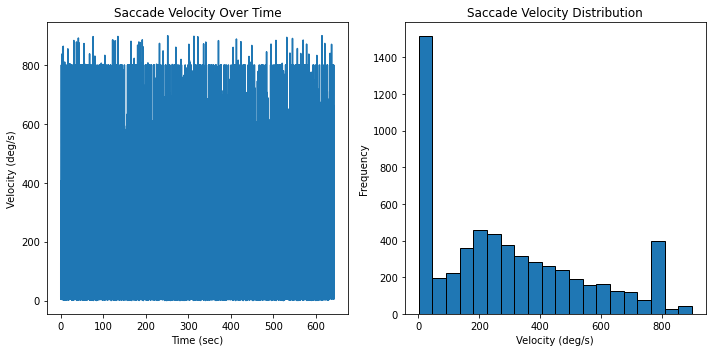

In [14]:
# Read the CSV file into a pandas DataFrame
data = pd.read_csv(f'{common_path}merged_data.csv')

# Filter data for saccades
saccade_data = data[data['Eye movement type'] == 'Saccade']

# Convert Cartesian coordinates to spherical coordinates
r, theta, psi = cart_to_spherical(saccade_data, apply_rad2deg=True)

# Calculate gaze velocity
dtheta_dt, dpsi_dt = get_velocity(saccade_data['timestamp'] / 1000000, theta, psi)
deg_per_sec = np.sqrt(dtheta_dt ** 2 + dpsi_dt ** 2)

for x in range(len(deg_per_sec)):
    if deg_per_sec[x]>900:
        deg_per_sec[x] = 800

# Count number of saccades
n_saccades = len(saccade_data)
print("Number of saccades:", n_saccades)

time = (data.timestamp[:-1] - data.timestamp.iloc[0])/1000000
# getting density distribution vs. amplitude and fixation duration
amplitude = np.sqrt(theta**2 + psi**2)
### mean saccade speed
meanSpeed = 0
for i in amplitude:
    meanSpeed = meanSpeed + i

meanSpeed = meanSpeed/n_saccades
print('Mean saccade speed is ', meanSpeed, '(deg/s)')
# Visualizing Gaze Velocity
plt.figure(figsize=(10, 5))

# Plot gaze velocity over time
plt.subplot(1, 2, 1)
plt.plot((saccade_data['timestamp'].values[:-1] - saccade_data['timestamp'].values[0]) / 1000000, deg_per_sec)
plt.xlabel("Time (sec)")
plt.ylabel("Velocity (deg/s)")
plt.title("Saccade Velocity Over Time")

# Plot gaze velocity distribution
plt.subplot(1, 2, 2)
plt.hist(deg_per_sec, bins=20, edgecolor='black')
plt.xlabel("Velocity (deg/s)")
plt.ylabel("Frequency")
plt.title("Saccade Velocity Distribution")

plt.tight_layout()
plt.show()